In [16]:
# %python3 -m pip install -r requirements.txt
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

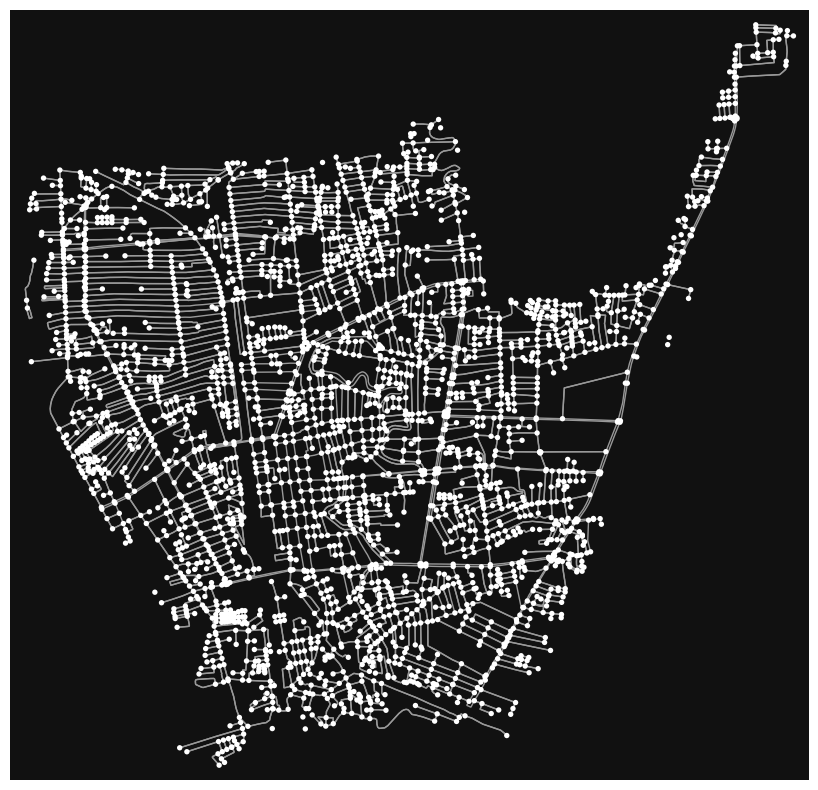

In [17]:
place_name = "Hat Yai District, Songkhla, Thailand"
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

# Build full graph from place
graph = load_graph()

# Polygon filter
area_coordinates = [
    (100.502769, 7.037112),
    (100.506839, 7.036403),
    (100.484659, 6.981756),
    (100.483150, 6.987053),
    (100.467264, 6.986236),
    (100.466289, 6.983138),
    (100.461562, 6.984726),
    (100.460087, 6.997991),
    (100.451423, 7.006697),
    (100.450599, 7.022179),
    (100.452207, 7.026726),
    (100.477673, 7.027629),
    (100.478553, 7.030400),
    (100.481593, 7.031277),
    (100.484508, 7.017035),
    (100.496636, 7.018713),
]
polygon = Polygon(area_coordinates)

# Clip graph to polygon
graph_filtered = ox.truncate.truncate_graph_polygon(graph, polygon)

# Plot
fig, ax = ox.plot_graph(graph_filtered, figsize=(12, 10))

In [18]:
edges = ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)

In [19]:
edges.columns

Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel'],
      dtype='object')

In [20]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_filtered)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])
# Export nodes and edges to CSV files
nodes_csv = nodes.copy()
# Convert geometry to separate lat/lon columns for CSV export
nodes_csv['longitude'] = nodes_csv.geometry.x
nodes_csv['latitude'] = nodes_csv.geometry.y
nodes_csv = nodes_csv.drop('geometry', axis=1)

edges_csv = edges.copy()
# Drop geometry column for CSV export as it's complex
edges_csv = edges_csv.drop('geometry', axis=1)

# Export to CSV
nodes_csv.to_csv('data/raw/road/hatyai_nodes.csv', index=True)
edges_csv.to_csv('data/raw/road/hatyai_edges.csv', index=True)

print(f"\nExported data:")
print(f"Nodes exported to 'hatyai_nodes.csv' ({len(nodes_csv)} records)")
print(f"Edges exported to 'hatyai_edges.csv' ({len(edges_csv)} records)")


Network Statistics:
Number of nodes: 3029
Number of edges: 6999

Nodes columns: ['y', 'x', 'highway', 'street_count', 'junction', 'geometry']

Edges columns: ['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel']

Network bounds (lon_min, lat_min, lon_max, lat_max): [100.4511039   6.9839845 100.5063432   7.0369187]
u            v            key
485580824    8642774010   0       48.863447
             4900465156   0       52.419118
             12008685153  0      269.444197
             13368519214  0       94.990321
485580829    3307271116   0        7.747836
                                    ...    
13434451561  13434451561  1      292.894345
13437630804  2506092381   0        1.884666
                          1        1.884666
             2506092132   0       43.923334
             2506092371   0       88.701742
Name: length, Length: 6999, dtype: float64

Exported data:
Nodes exported to 'hat

In [21]:
nodes = pd.read_csv('data/raw/road/hatyai_nodes.csv')
edges = pd.read_csv('data/raw/road/hatyai_edges.csv')

In [22]:
# Add edge/node capacities using length and lanes (default lane width 3.5 m)

def add_capacity(nodes_df, edges_df, lane_width=3.5, default_lanes=1):

    edges_df = edges_df.copy()

    nodes_df = nodes_df.copy()

    lanes_numeric = pd.to_numeric(edges_df.get("lanes"), errors="coerce")

    lanes_numeric = lanes_numeric.fillna(default_lanes).clip(lower=default_lanes)

    edges_df["lanes_clean"] = lanes_numeric

    edges_df["capacity"] = edges_df["length"].fillna(0) * lane_width * edges_df["lanes_clean"]

    node_capacity = (

        pd.concat(

            [

                edges_df[["u", "capacity"]].rename(columns={"u": "osmid"}),

                edges_df[["v", "capacity"]].rename(columns={"v": "osmid"}),

            ]

        )

        .groupby("osmid")["capacity"]

        .sum()

        .rename("capacity")

    )

    nodes_df = nodes_df.merge(node_capacity, on="osmid", how="left")

    nodes_df["capacity"] = nodes_df["capacity"].fillna(0)

    return nodes_df, edges_df



nodes, edges = add_capacity(nodes, edges)

nodes.to_csv("data/clean/hatyai_nodes_with_capacity.csv", index=False)

edges.to_csv("data/clean/hatyai_edges_with_capacity.csv", index=False)

print(

    "Capacities added: "

    f"nodes with capacity={len(nodes)}; "

    f"edges with capacity={len(edges)}; "

    f"lane width={3.5}m"

)

Capacities added: nodes with capacity=3029; edges with capacity=6999; lane width=3.5m


In [23]:
# Load shelters from text file and save as GeoDataFrame

def load_shelters(txt_path="data/tmp/โรงเรียนในหาดใหญ่.txt"):

    # Expect lines: name, lat, lon

    shelters = pd.read_csv(

        txt_path,

        header=None,

        names=["name", "lat", "lon"],

        sep=",",

        engine="python",

        skipinitialspace=True,

    )

    shelters["lat"] = shelters["lat"].astype(float)

    shelters["lon"] = shelters["lon"].astype(float)

    shelters_gdf = gpd.GeoDataFrame(

        shelters,

        geometry=gpd.points_from_xy(shelters["lon"], shelters["lat"]),

        crs="EPSG:4326",

    )

    shelters_gdf.to_csv("data/clean/hatyai_shelters.csv", index=False)

    return shelters_gdf



shelters = load_shelters()

print(f"Shelters loaded: {len(shelters)}")

print(shelters.head())

Shelters loaded: 34
                                  name       lat         lon  \
0  โรงเรียนเทศบาล 1 (เอ็งเสียงสามัคคี)  7.016168  100.470097   
1       โรงเรียนเทศบาล 2 (บ้านหาดใหญ่)  7.002162  100.460692   
2      โรงเรียนเทศบาล 4 (วัดคลองเรียน)  6.998946  100.486615   
3        โรงเรียนเทศบาล 5 (วัดหาดใหญ่)  7.003150  100.454090   
4       โรงเรียนเทศบาล 6 (อนุบาลในฝัน)  7.001546  100.459038   

                    geometry  
0   POINT (100.4701 7.01617)  
1  POINT (100.46069 7.00216)  
2  POINT (100.48662 6.99895)  
3  POINT (100.45409 7.00315)  
4  POINT (100.45904 7.00155)  


In [24]:
# Attach shelters onto nearest road nodes

def attach_shelters_to_nodes(nodes_df, shelters_gdf):

    nodes_geo = gpd.GeoDataFrame(

        nodes_df.copy(),

        geometry=gpd.points_from_xy(nodes_df.x, nodes_df.y),

        crs="EPSG:4326",

    )

    nearest = gpd.sjoin_nearest(

        shelters_gdf,

        nodes_geo,

        how="left",

        distance_col="shelter_node_dist_deg",

    )

    grouped = nearest.groupby("index_right").agg(

        shelter_names=("name", lambda s: "; ".join(sorted(set(s.dropna())))),

        shelter_min_dist_deg=("shelter_node_dist_deg", "min"),

    )

    nodes_out = nodes_df.copy()

    nodes_out["is_shelter"] = False

    nodes_out["shelter_names"] = np.nan

    nodes_out["shelter_min_dist_deg"] = np.nan

    nodes_out.loc[grouped.index, "is_shelter"] = True

    nodes_out.loc[grouped.index, "shelter_names"] = grouped["shelter_names"].values

    nodes_out.loc[grouped.index, "shelter_min_dist_deg"] = grouped[

        "shelter_min_dist_deg"

    ].values

    return nodes_out



nodes = attach_shelters_to_nodes(nodes, shelters)

nodes.to_csv("data/clean/hatyai_nodes_with_capacity_and_shelter.csv", index=False)

print("Shelters attached to nodes:", nodes["is_shelter"].sum())

Shelters attached to nodes: 34


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_57811/3516669418.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['โรงเรียนวิริยะเธียรวิทยา' 'โรงเรียนสหศาสตร์วิทยาคาร' 'โรงเรียนพัฒนศึกษา'
 'โรงเรียนเทศบาล 6 (อนุบาลในฝัน)' 'โรงเรียนธรรมศึกษามูลนิธิ'
 'โรงเรียนเทศบาล 2 (บ้านหาดใหญ่)' 'โรงเรียนพลวิทยา'
 'โรงเรียนศรีนครมูลนิธิ' 'โรงเรียนเทศบาล 5 (วัดหาดใหญ่)'
 'โรงเรียนพลวิทยาระบบสองภาษา' 'โรงเรียนนานาชาติอเมริกัน เพรพ'
 'โรงเรียนสุวรรณวงศ์' 'โรงเรียนคุณธรรมวิทยา' 'โรงเรียนสมานคุณวิทยาทาน'
 'โรงเรียนเทพอำนวยหาดใหญ่' 'โรงเรียนทิพรัตน์วิทยาคาร'
 'โรงเรียนธิดานุเคราะห์' 'โรงเรียนอนุบาลกุลจิ

In [25]:
# Randomly allocate population/households across nodes
pop_male = 64864
pop_female = 75987
pop_total = 140851
households = 70703

rng = np.random.default_rng(888)
n = len(nodes)
weights = np.ones(n) / n

nodes["pop_male"] = rng.multinomial(pop_male, weights)
nodes["pop_female"] = rng.multinomial(pop_female, weights)
nodes["pop_total"] = nodes["pop_male"] + nodes["pop_female"]
nodes["households"] = rng.multinomial(households, weights)

print("Population assigned:"
      f" male={nodes['pop_male'].sum()}"
      f" female={nodes['pop_female'].sum()}"
      f" total={nodes['pop_total'].sum()}"
      f" households={nodes['households'].sum()}")

nodes.to_csv("data/clean/hatyai_nodes_with_pop.csv", index=False)
print("Saved with population -> data/clean/hatyai_nodes_with_pop.csv")

Population assigned: male=64864 female=75987 total=140851 households=70703
Saved with population -> data/clean/hatyai_nodes_with_pop.csv


In [27]:
# Load flood grid data for two time steps (t1, t2) and compute change
flood_t1 = pd.read_csv("data/tmp/filtered_bc5_20251124_2200_locations_inside.csv")
flood_t2 = pd.read_csv("data/tmp/filtered_rd2_20251126_1800_locations_inside.csv")

delta_hours = 44  # hours between 2025-11-24 22:00 and 2025-11-26 18:00

# Build GeoDataFrames for nearest-neighbor join
flood_gdf_t1 = gpd.GeoDataFrame(
    flood_t1,
    geometry=gpd.points_from_xy(flood_t1.x, flood_t1.y),
    crs="EPSG:4326",
)
flood_gdf_t2 = gpd.GeoDataFrame(
    flood_t2,
    geometry=gpd.points_from_xy(flood_t2.x, flood_t2.y),
    crs="EPSG:4326",
)
nodes_gdf = gpd.GeoDataFrame(
    nodes.copy(),
    geometry=gpd.points_from_xy(nodes.x, nodes.y),
    crs="EPSG:4326",
)

# Attach nearest flood gridcode to each node for both times
nodes_t1 = gpd.sjoin_nearest(
    nodes_gdf,
    flood_gdf_t1[["gridcode", "geometry"]],
    how="left",
    distance_col="flood_distance_t1_deg",
)
nodes_t1 = nodes_t1.rename(columns={"gridcode": "flood_level_t1"}).drop(columns=["index_right"])

nodes_t2 = gpd.sjoin_nearest(
    nodes_gdf,
    flood_gdf_t2[["gridcode", "geometry"]],
    how="left",
    distance_col="flood_distance_t2_deg",
)
nodes_t2 = nodes_t2.rename(columns={"gridcode": "flood_level_t2"}).drop(columns=["index_right"])

# Combine t1 and t2
nodes_with_flood = nodes_t1.drop(columns=["geometry"]).merge(
    nodes_t2.drop(columns=["geometry"])[["osmid", "flood_level_t2", "flood_distance_t2_deg"]],
    on="osmid",
    how="left",
)
nodes_with_flood["flood_delta"] = nodes_with_flood["flood_level_t2"] - nodes_with_flood["flood_level_t1"]
nodes_with_flood["flood_rate_m_per_hr"] = nodes_with_flood["flood_delta"] / delta_hours

# Propagate flood levels to edges using the max of endpoint levels (dedupe osmid first)
node_flood_t1 = nodes_with_flood.groupby("osmid")["flood_level_t1"].max()
node_flood_t2 = nodes_with_flood.groupby("osmid")["flood_level_t2"].max()
edges_with_flood = edges.copy()
edges_with_flood["flood_level_t1_u"] = edges_with_flood["u"].map(node_flood_t1)
edges_with_flood["flood_level_t1_v"] = edges_with_flood["v"].map(node_flood_t1)
edges_with_flood["flood_level_t2_u"] = edges_with_flood["u"].map(node_flood_t2)
edges_with_flood["flood_level_t2_v"] = edges_with_flood["v"].map(node_flood_t2)
edges_with_flood["flood_level_t1"] = edges_with_flood[["flood_level_t1_u", "flood_level_t1_v"]].max(axis=1)
edges_with_flood["flood_level_t2"] = edges_with_flood[["flood_level_t2_u", "flood_level_t2_v"]].max(axis=1)
edges_with_flood["flood_delta"] = edges_with_flood["flood_level_t2"] - edges_with_flood["flood_level_t1"]
edges_with_flood["flood_rate_m_per_hr"] = edges_with_flood["flood_delta"] / delta_hours

# Save results
nodes_with_flood.to_csv("data/clean/hatyai_nodes_flood_t1_t2.csv", index=False)
edges_with_flood.to_csv("data/clean/hatyai_edges_flood_t1_t2.csv", index=False)

print("Flood attributes attached (t1 & t2):")
print(nodes_with_flood[["osmid", "flood_level_t1", "flood_level_t2", "flood_delta", "flood_rate_m_per_hr"]].head())
print(edges_with_flood[["u", "v", "flood_level_t1", "flood_level_t2", "flood_delta", "flood_rate_m_per_hr"]].head())

Flood attributes attached (t1 & t2):
       osmid  flood_level_t1  flood_level_t2  flood_delta  flood_rate_m_per_hr
0  485580824               1               3            2             0.045455
1  485580824               1               3            2             0.045455
2  485580829               4               3           -1            -0.022727
3  485580840               5               3           -2            -0.045455
4  485580841               5               3           -2            -0.045455
           u            v  flood_level_t1  flood_level_t2  flood_delta  \
0  485580824   8642774010               1               3            2   
1  485580824   4900465156               2               3            1   
2  485580824  12008685153               1               3            2   
3  485580824  13368519214               1               4            3   
4  485580829   3307271116               4               3           -1   

   flood_rate_m_per_hr  
0             0.045

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


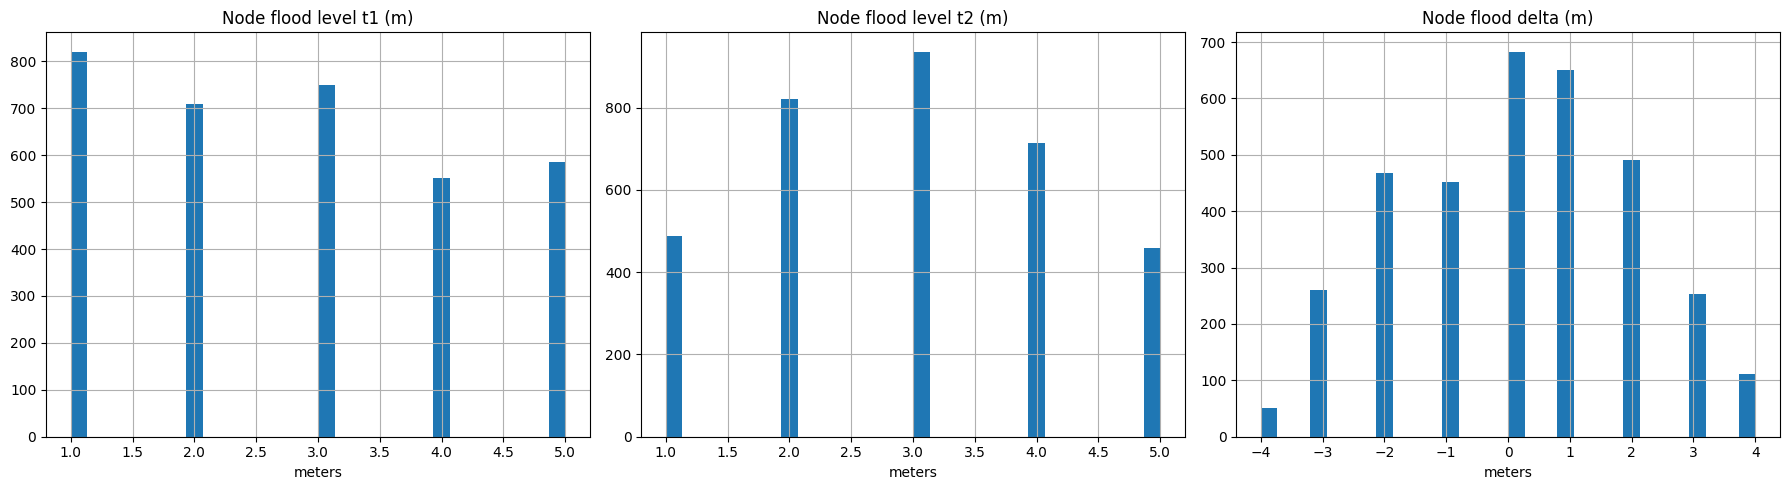

In [30]:
# Quick visuals: flood levels, deltas, and map
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
nodes_with_flood["flood_level_t1"].hist(ax=axes[0], bins=30)
axes[0].set_title("Node flood level t1 (m)")
nodes_with_flood["flood_level_t2"].hist(ax=axes[1], bins=30)
axes[1].set_title("Node flood level t2 (m)")
nodes_with_flood["flood_delta"].hist(ax=axes[2], bins=30)
axes[2].set_title("Node flood delta (m)")
for ax in axes:
    ax.set_xlabel("meters")
plt.tight_layout()
plt.show()


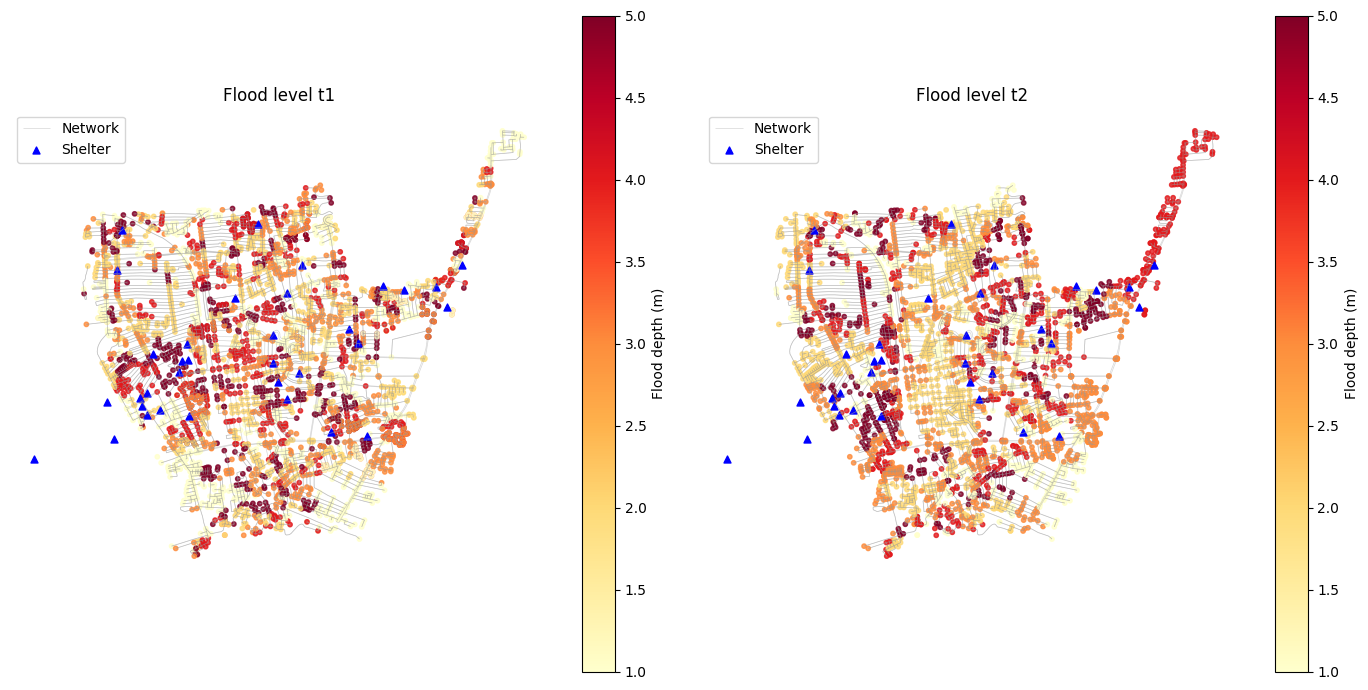

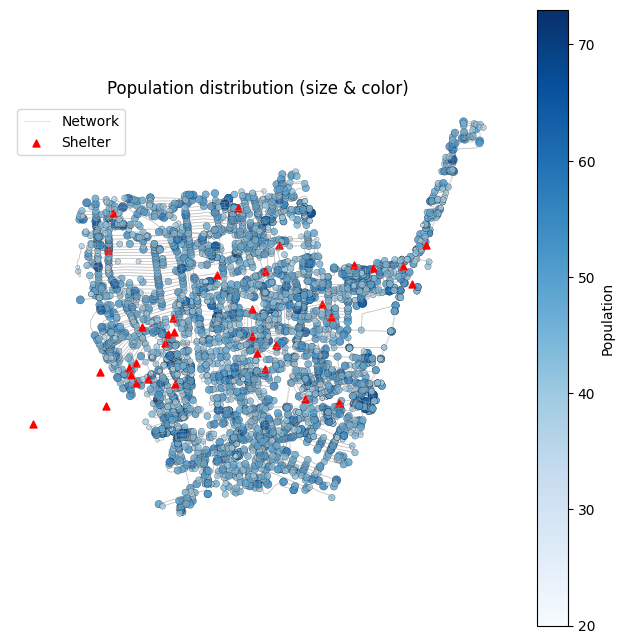

In [34]:
# Maps: separate flood levels (t1, t2) with network, and population colored by size
nodes_plot = gpd.GeoDataFrame(
    nodes_with_flood,
    geometry=gpd.points_from_xy(nodes_with_flood.x, nodes_with_flood.y),
    crs="EPSG:4326",
)
edges_geom = (
    ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)
    .reset_index()[["u", "v", "key", "geometry"]]
)

# Flood level maps (fixed marker size) + network lines
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, col, title in zip(
    axes,
    ["flood_level_t1", "flood_level_t2"],
    ["Flood level t1", "Flood level t2"],
):
    edges_geom.plot(ax=ax, color="#999", linewidth=0.5, alpha=0.4, label="Network")
    nodes_plot.plot(
        ax=ax,
        column=col,
        cmap="YlOrRd",
        markersize=10,
        alpha=0.8,
        legend=True,
        legend_kwds={"label": "Flood depth (m)"},
    )
    shelters.plot(ax=ax, color="blue", markersize=25, marker="^", label="Shelter")
    ax.set_title(title)
    ax.set_axis_off()
    ax.legend()
plt.tight_layout()
plt.show()

# Population map (size and color by pop_total) + network lines
pop_series = nodes_with_flood.get("pop_total")
if pop_series is None:
    pop_series = pd.Series(1, index=nodes_with_flood.index)
pop_norm = (pop_series - pop_series.min()).clip(lower=1)
pop_size = 50 * pop_norm / pop_norm.max()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
edges_geom.plot(ax=ax, color="#999", linewidth=0.5, alpha=0.4, label="Network")
nodes_plot.plot(
    ax=ax,
    column=pop_series,
    cmap="Blues",
    markersize=pop_size,
    alpha=0.8,
    edgecolor="k",
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "Population"},
)
shelters.plot(ax=ax, color="red", markersize=25, marker="^", label="Shelter")
ax.set_title("Population distribution (size & color)")
ax.set_axis_off()
ax.legend()
plt.show()